An initial attempt at a study justifying the number of iterations used for Uni-/MultiFold.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Generic imports
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import tensorflow as tf

### Custom functions
from omnifold import *
from omnifold.utilities import *

2021-10-15 17:52:08.259127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
! nvidia-smi -L # list GPUs available

GPU 0: Tesla V100-PCIE-16GB (UUID: GPU-b2eedb47-e26d-4e8b-5f08-28bd60cb8c80)
GPU 1: Tesla V100-PCIE-16GB (UUID: GPU-330a175b-ca34-c7af-fff6-a665d8225488)
GPU 2: NVIDIA GeForce GT 710 (UUID: GPU-38820045-e66c-3d13-0512-e926ac5928ef)


In [4]:
### GPU Setup
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-10-15 17:52:10.234068: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-15 17:52:10.235205: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-15 17:52:10.273789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-10-15 17:52:10.273837: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-15 17:52:10.276101: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-15 17:52:10.276159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [5]:
plot_setup()
plt.rcParams.update({"font.family": "serif",})

In [6]:
plot_dir = './plots/'

### Load files

Since we're not using data yet, "MC" = Powheg + Pythia8 MC16e and "data" = Sherpa 2.2.1 MC16e.

In [7]:
folder = '/data0/mpettee/omnifold_data/'

In [8]:
f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root")
f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root")

In [9]:
columns = f_mc['OmniTree'].keys()

These columns are the same for both samples, since they're both MC:

In [10]:
f_mc['OmniTree'].keys() == f_data['OmniTree'].keys()

True

Note that variables ending in `_tracks` require MultiIndex-ing. It's possible to combine these with flat variables, but it does increase the size of the DataFrame considerably: 

In [11]:
# [col for col in columns if col.endswith("_tracks")]

In [12]:
# f_mc['OmniTree'].arrays(
#     ["weight","pT_tracks"],
#     library="pd")

Let's ignore the MultiIndex variables for now.

In [13]:
mc = f_mc['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

data = f_data['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

print("MC has {:,} events with {} columns.".format(mc.shape[0],mc.shape[1]))
print("Data has {:,} events with {} columns.".format(data.shape[0],data.shape[1]))

MC has 416,725 events with 57 columns.
Data has 3,578,623 events with 57 columns.


### Apply event selection

In [14]:
mc['pass190'] = mc['pass190'].astype('bool')
mc['truth_pass190'] = mc['truth_pass190'].astype('bool')
data['pass190'] = data['pass190'].astype('bool')
data['truth_pass190'] = data['truth_pass190'].astype('bool')

In [15]:
### The sample we're using already has these cuts applied, but we'll keep them in for future datasets. 
mc = mc[(mc.pass190 | mc.truth_pass190)]
data = data[data.pass190]
data_truth = data[data.truth_pass190]

In [16]:
## JUST FOR FUN/OPTIONAL: add a large offset to 10% of the true data, for fun
# data_truth_weights[:343775] = data_truth_weights[:343775]*10

Normalize the weights:

In [17]:
for weights in [mc.weight_mc, mc.weight, data_truth.weight_mc, data.weight]:
    weights /= np.mean(weights)

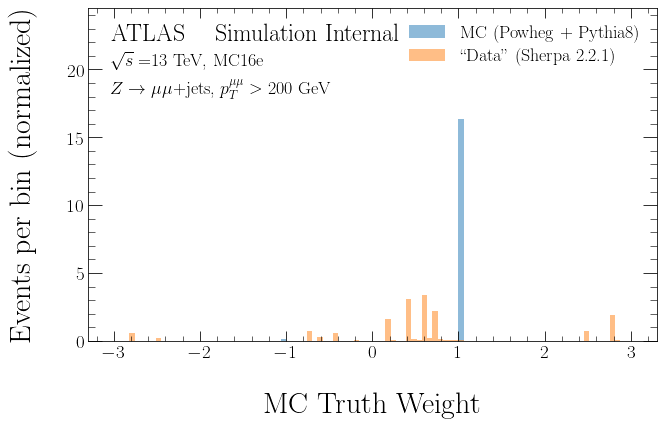

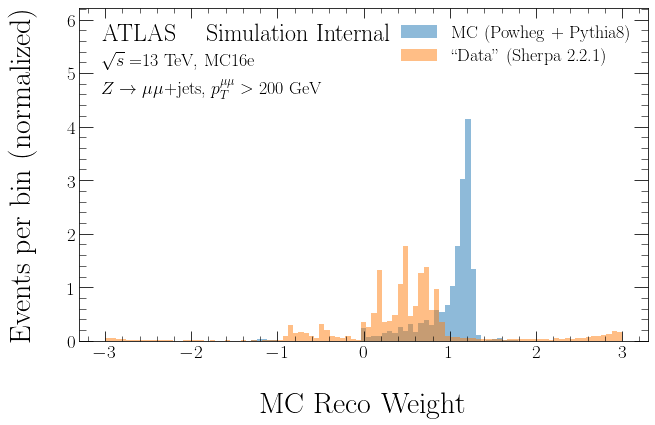

In [18]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_sim_truth, _, _ = plt.hist(mc.weight_mc,
                              bins=bins,
                              label=r'MC (Powheg + Pythia8)',
                              **plot_style_2)
hW_data_truth, _, _ = plt.hist(data_truth.weight_mc,
                               bins=bins,
                               label=r'``Data" (Sherpa 2.2.1)',
                               **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
plt.legend()
draw_atlas_text()
plt.show()

plt.figure(figsize=(10, 6))
hW_sim_reco, _, _ = plt.hist(mc.weight,
                             bins=bins,
                             label=r'MC (Powheg + Pythia8)',
                             **plot_style_2)
hW_data_reco, _, _ = plt.hist(data.weight,
                              bins=bins,
                              label=r'``Data" (Sherpa 2.2.1)',
                              **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
plt.legend()
draw_atlas_text()
plt.show()

### Load IBU histograms to get binning

In [19]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]
plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

In [20]:
IBU_hists = uproot.open(folder+'unfoldingPlotsJune14_UnfoldedHists.root')

bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]

In [21]:
labels_and_bins = zip(file_labels, plot_labels, bins)

ibu_hists = []

for file_label, plot_label, plot_bins in labels_and_bins:
    ibu_hists += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

In [22]:
### Replace bins with Laura's new binning! 
ibu_hists[0]['bins'] = np.array([1, 7, 11, 15, 20, 30, 40]) # leading jet n_charged_tracks
ibu_hists[4]['bins'] = np.array([0,  50,  100,  150,  200,  300,  1000]) # leading jet pT
ibu_hists[10]['bins'] = np.array([0,  0.05,  0.1,  0.17,  0.25,  0.35,  0.5,  0.9]) # leading jet tau_1

### Unifold (one trial)

In [23]:
K.clear_session()

In [24]:
save_label0 = 'test'

In [25]:
i = 0 # index of variable of interest (num_tracks for leading jet)
### Replace bins with Laura's new binning! 
ibu_hists[0]['bins'] = np.array([1,  7,  11,  15,  20,  30,  40]) 
bins = ibu_hists[i]['bins']
x_label = ibu_hists[i]['plot_label']
file_label = ibu_hists[i]['file_label']
os.makedirs(plot_dir+'UniFold/'+file_label, exist_ok=True)
save_label = plot_dir+'UniFold/'+file_label+'/'+save_label0
print("Saving as {}.".format(save_label))

Saving as ./plots/UniFold/Ntracks_trackj1/test.


Grab the particular variable you care about, and set a dummy value for events that don't pass each MC selection:

In [26]:
dummyval = -99
mc['truth_var'] = np.where(mc.truth_pass190, mc['truth_'+file_label], dummyval)
mc['reco_var'] = np.where(mc.pass190, mc[file_label], dummyval)
data_truth['truth_var'] = data_truth['truth_'+file_label]
data['reco_var'] = data[file_label]

/tmp/ipykernel_15299/2058628029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_truth['truth_var'] = data_truth['truth_'+file_label]


Plot this observable in MC & "data" before unfolding:

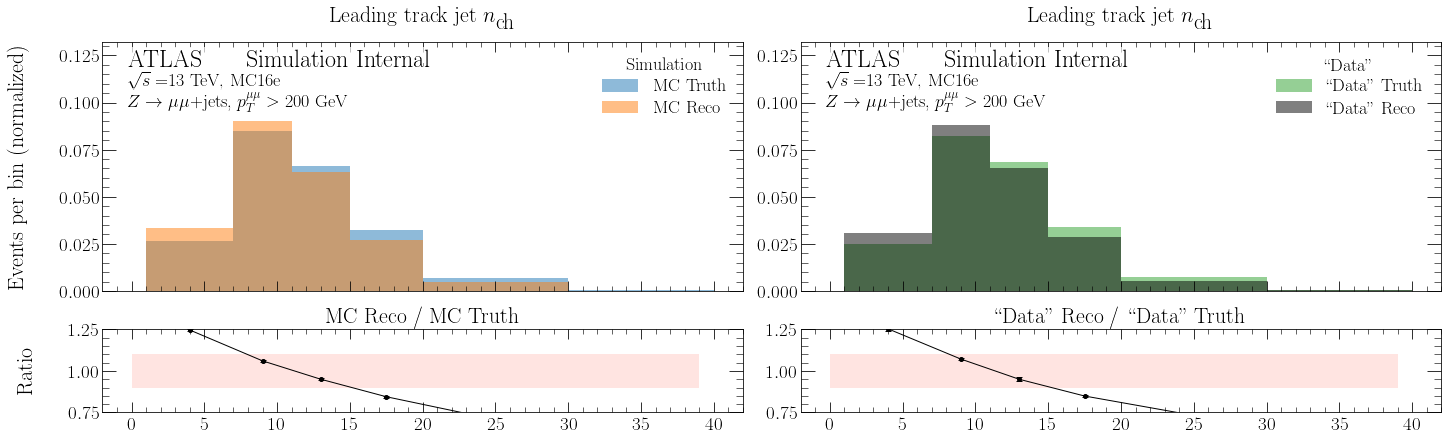

In [27]:
### Add in 200 GeV cuts for plotting only 
mc_plots = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
data_truth_plots = data_truth[data_truth.truth_pT_ll > 200]
data_plots = data[data.pT_ll > 200]

unifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_plots))) # the right size for the 200 GeV cut

plot_distributions(
    sim_truth=mc_plots.truth_var,
    sim_reco=mc_plots.reco_var,
    sim_truth_weights_MC=mc_plots.weight_mc,
    sim_reco_weights_MC=mc_plots.weight,
    data_truth=data_truth_plots.truth_var,
    data_reco=data_plots.reco_var,
    data_truth_weights_MC=data_truth_plots.weight_mc,
    data_reco_weights_MC=data_plots.weight,
    bins=bins,
    x_label=x_label,
    save_label=save_label
)

Standardize the data by z-score:

In [28]:
mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc.truth_var), np.array(mc.reco_var), np.array(data.reco_var))

Unfold!

In [29]:
weights, _ = unifold(iterations=3,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc.weight_mc,
                     sim_reco_weights_MC=mc.weight,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data.weight,
                     dummyval=dummyval,
                     verbose=0,
                    )

2021-10-15 04:49:21.447944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-15 04:49:21.448996: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-15 04:49:21.450543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-10-15 04:49:21.450605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-15 04:49:21.450639: I tensorflow/stream_executor/platform/defaul

Store the weights for the dataset that passes 200 GeV:

In [30]:
filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)

unifold_weights[i] = best_1D_reweighting(
    test=mc_plots.reco_var,
    test_weights=np.array(mc_plots.weight) * weights[:,:,filter][:,1],
    target=data_plots.reco_var,
    target_weights=data_plots.weight,
    bins=bins)

100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.43s/it]


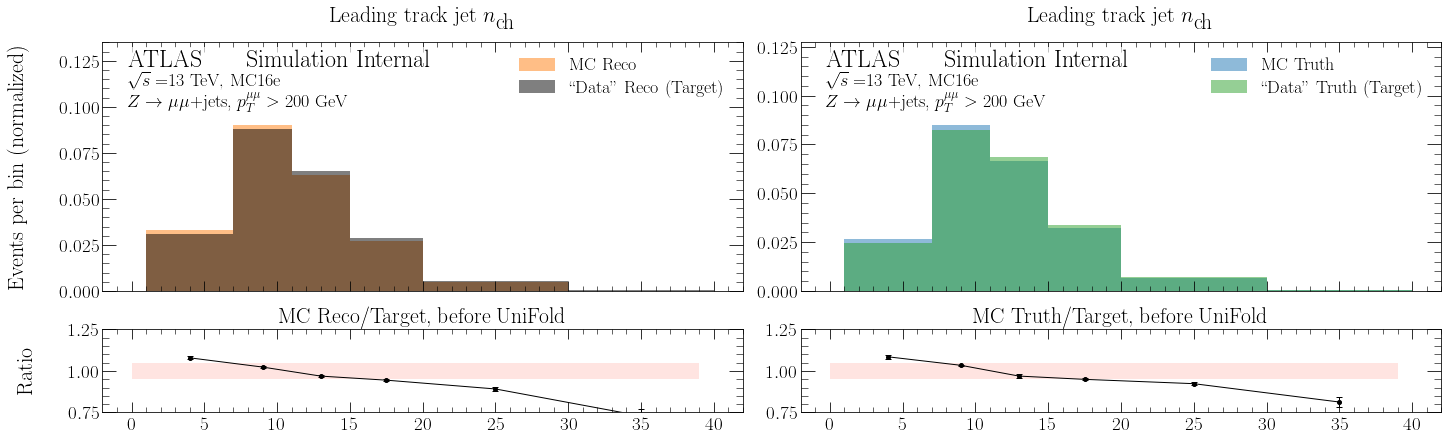

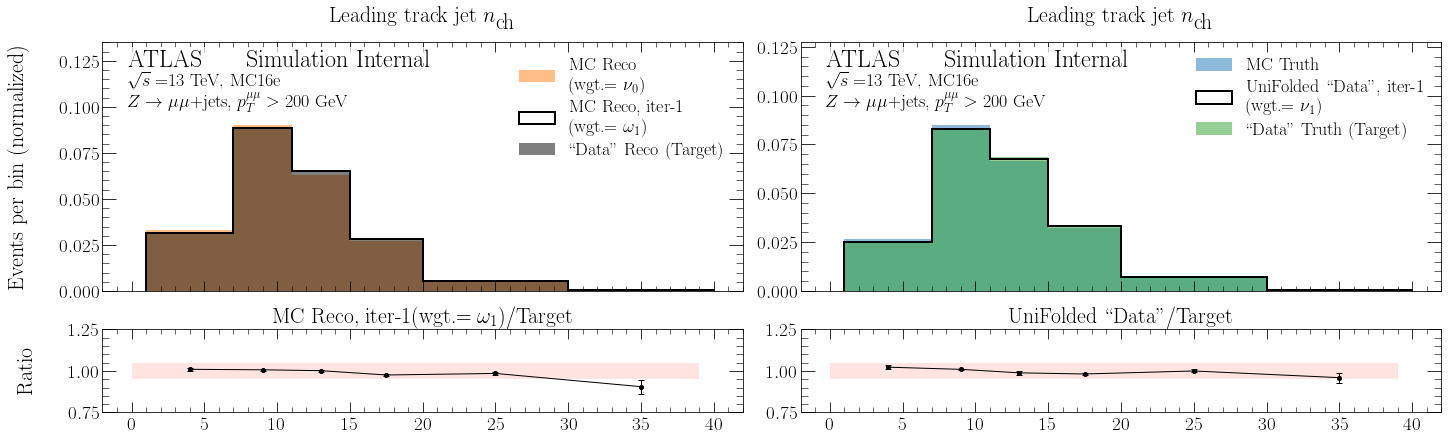

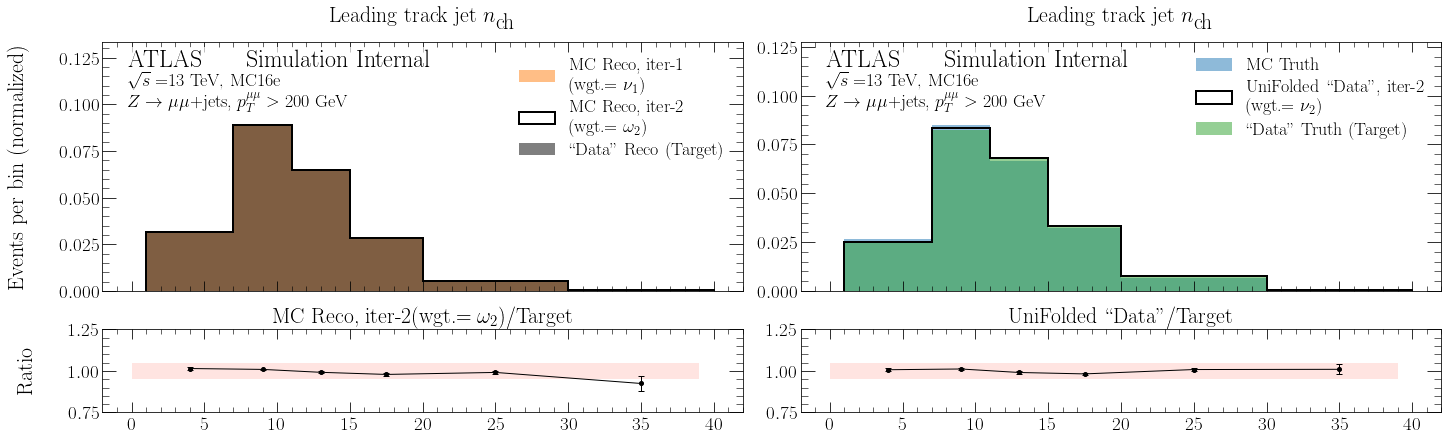

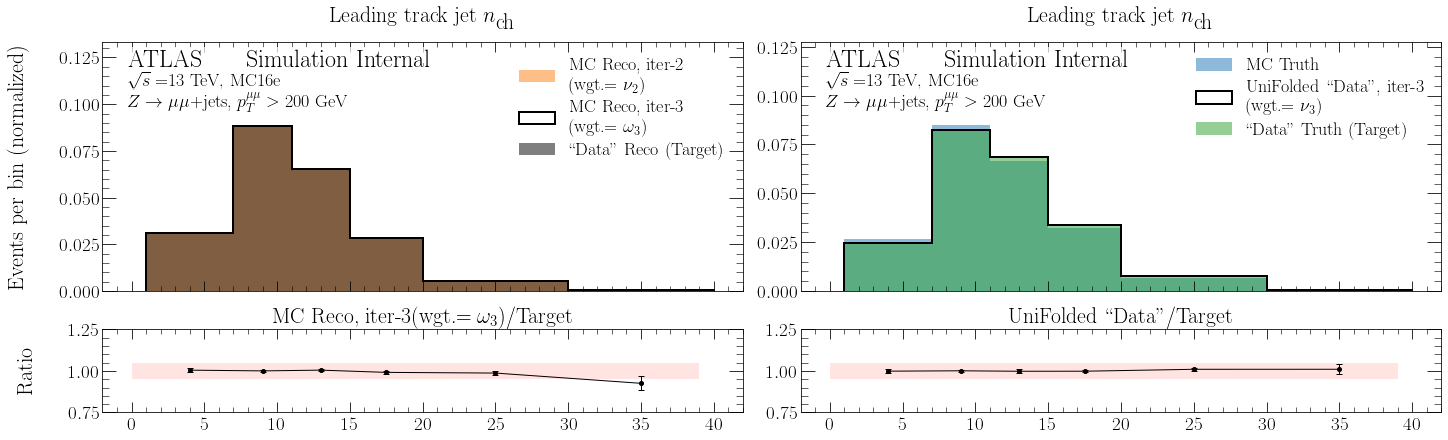

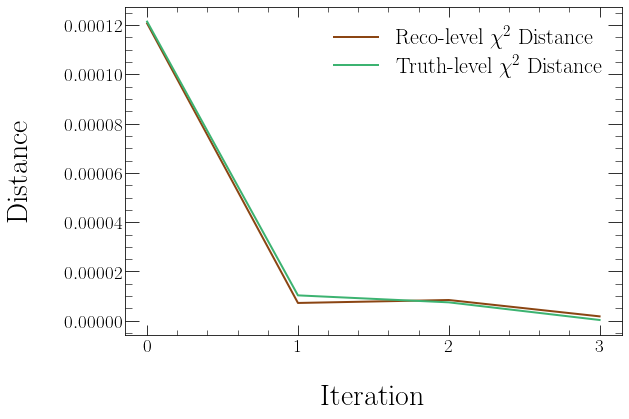

In [31]:
plot_results(sim_truth=mc_plots.truth_var,
             sim_reco=mc_plots.reco_var,
             sim_truth_weights_MC=mc_plots.weight_mc,
             sim_reco_weights_MC=mc_plots.weight,
             data_truth=data_truth_plots.truth_var,
             data_reco=data_plots.reco_var,
             data_truth_weights_MC=data_truth_plots.weight_mc,
             data_reco_weights_MC=data_plots.weight,
             weights=weights[:,:,filter],
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label
            )

### Run unfolding multiple times w/ Poisson bootstrapping to calculate statistical uncertainty:

Trial:   0%|                                                        | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_30723/2989079779.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_truth['truth_var'] = data_truth['truth_'+file_label]
2021-10-15 17:56:17.563660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-15 17:56:17.564883: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-15 17:56:17.567423:

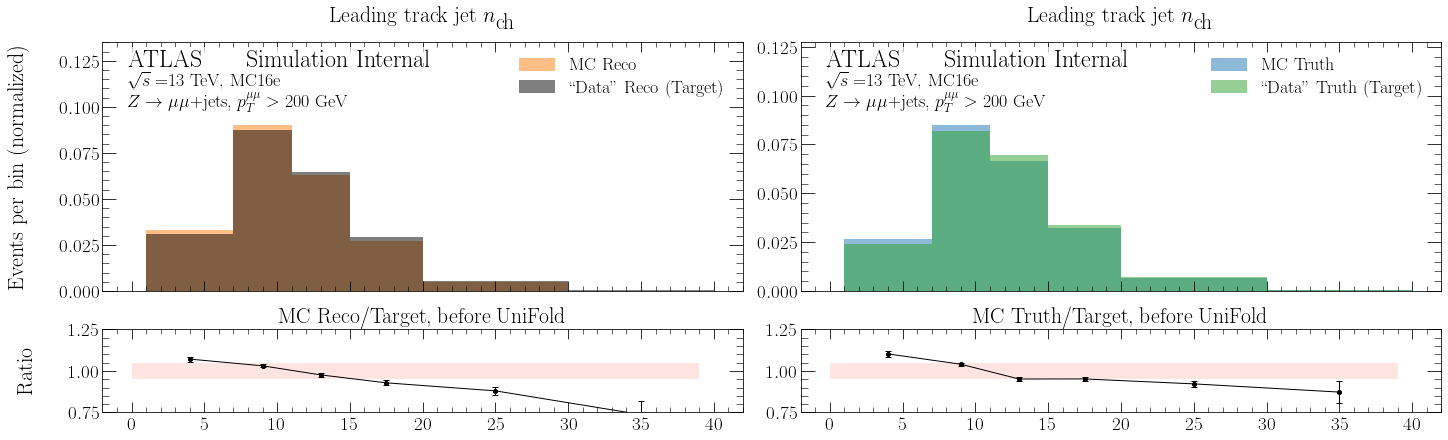

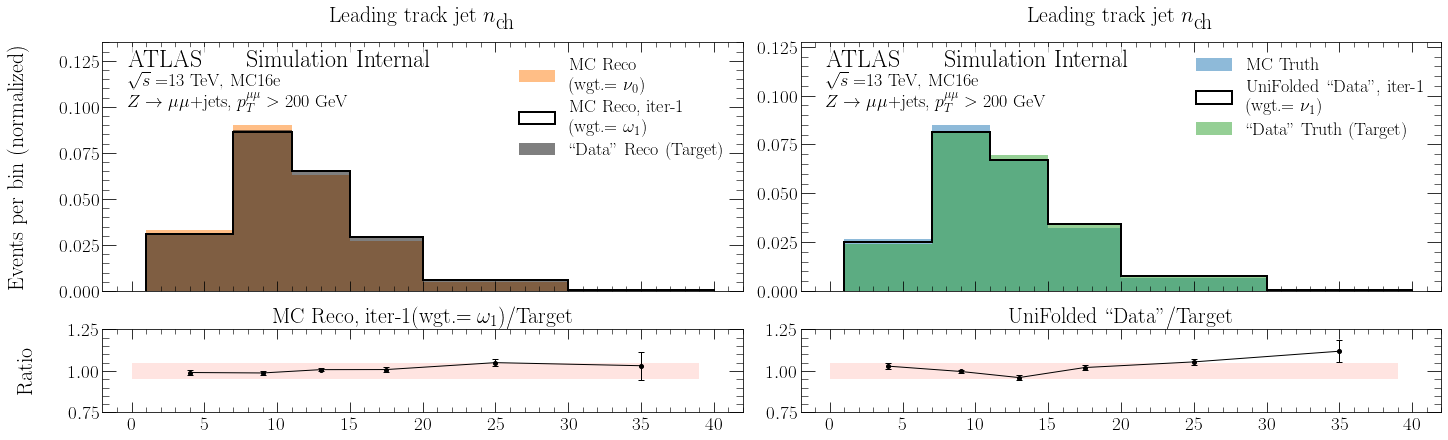

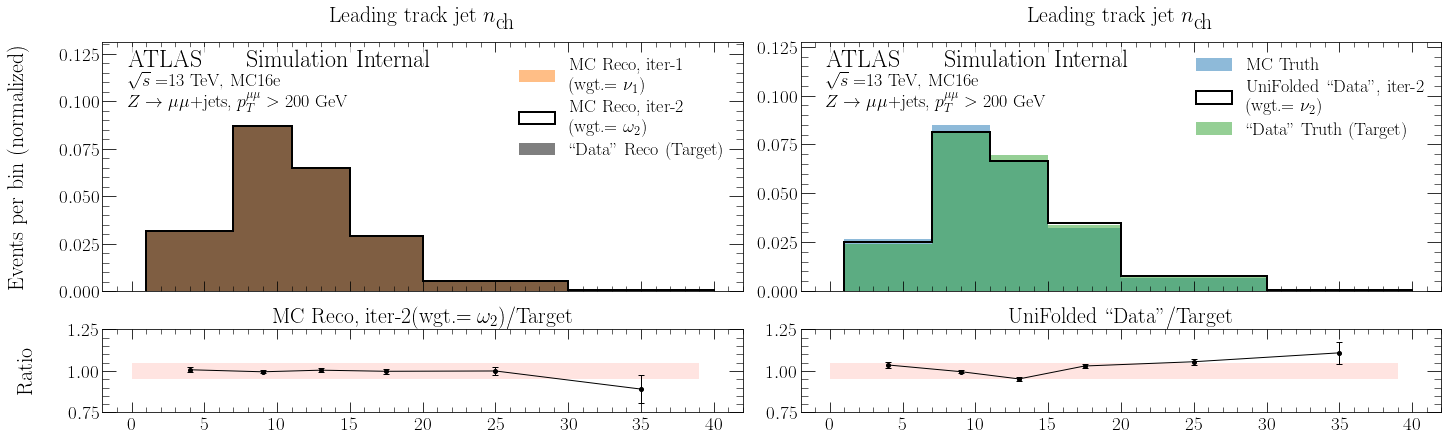

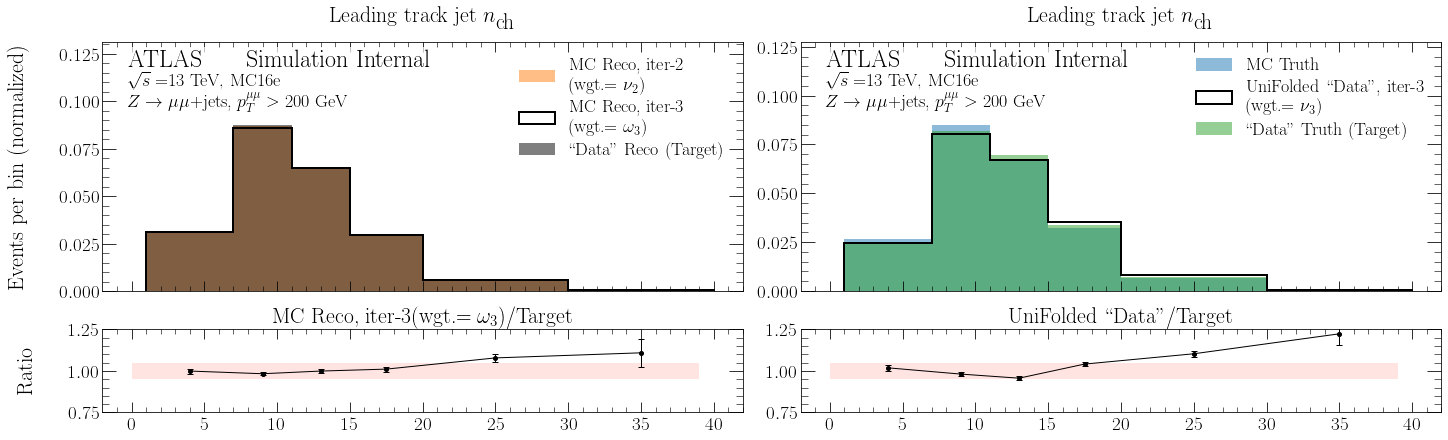

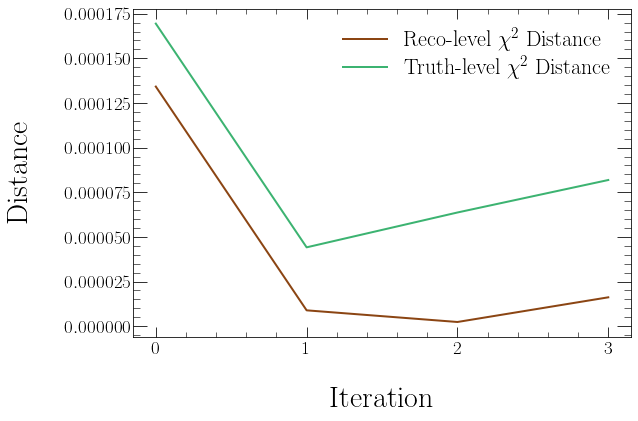

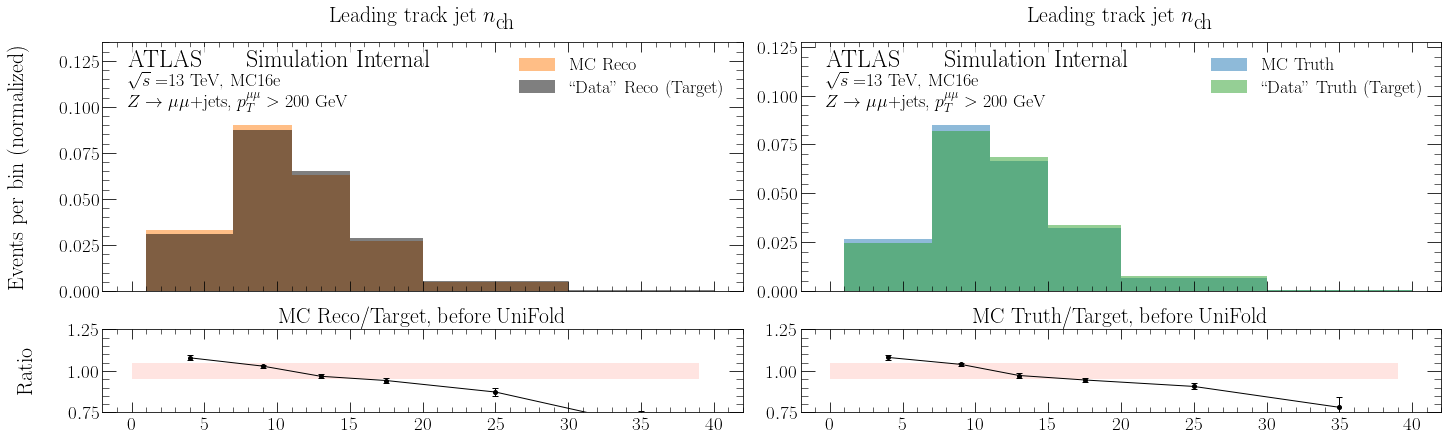

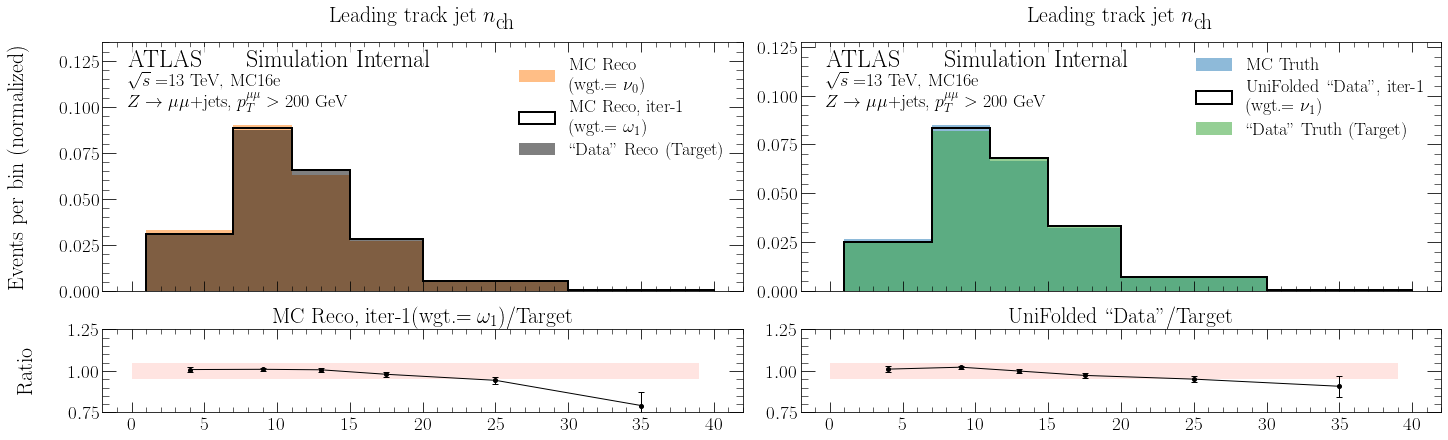

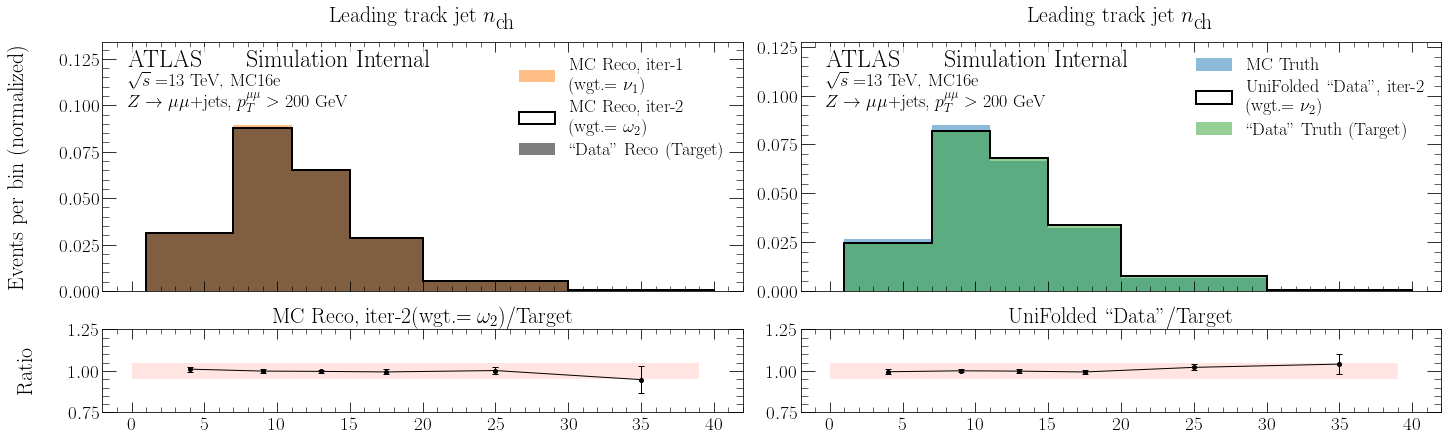

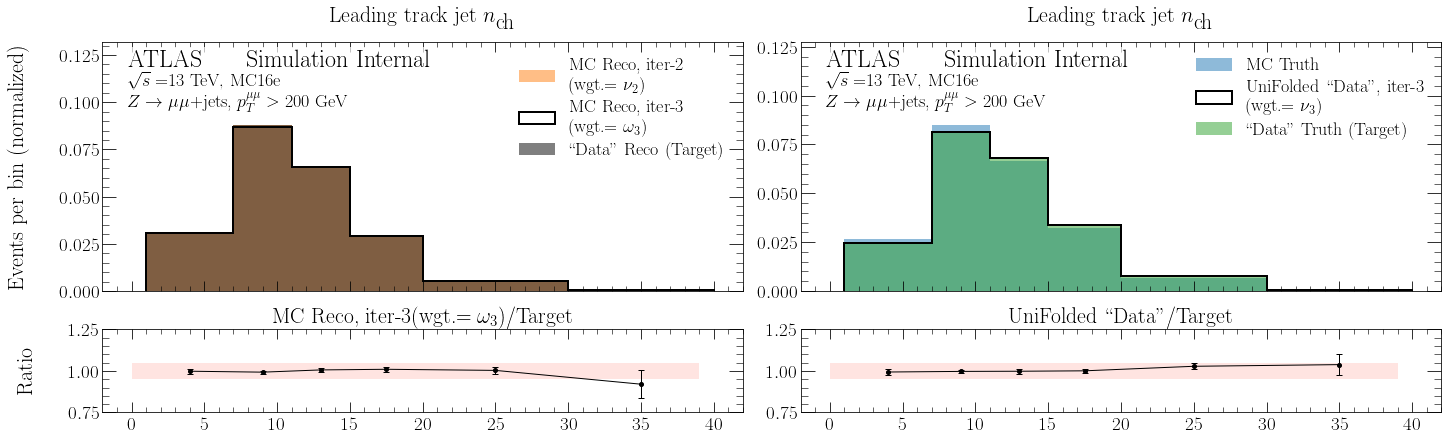

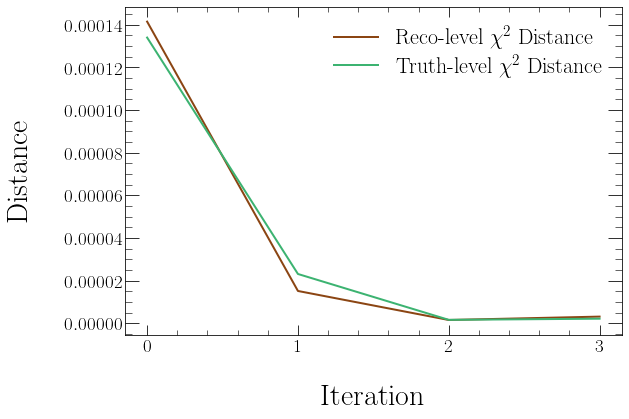

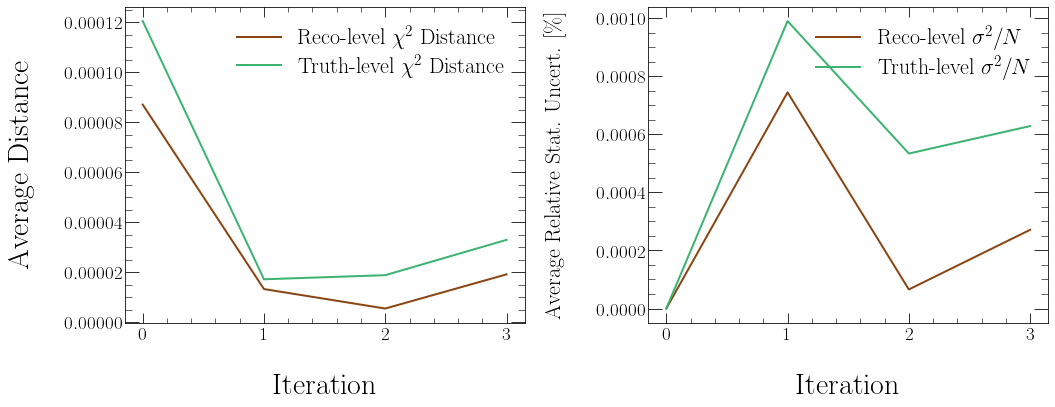

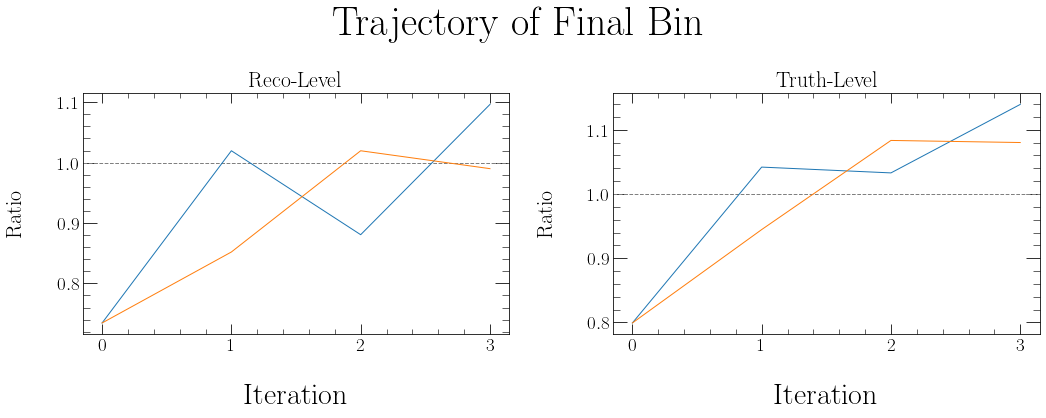

In [24]:
var_i = 0 # index of variable of interest (0 = num_tracks for leading jet) 
n_trials = 2        # how many full runs of unfolding
n_iterations = 3    # how many iterations per unfolding process

bins = ibu_hists[var_i]['bins']
x_label = ibu_hists[var_i]['plot_label']
file_label = ibu_hists[var_i]['file_label']

# Unifold result
reco_unfolded_hists = np.zeros((n_trials, n_iterations+1, len(bins)-1)) 
truth_unfolded_hists = np.zeros((n_trials, n_iterations+1, len(bins)-1))
reco_target_hists = np.zeros((n_trials, n_iterations+1, len(bins)-1)) 
truth_target_hists = np.zeros((n_trials, n_iterations+1, len(bins)-1))

# Chi-squared distances
reco_distances = np.zeros((n_trials, n_iterations+1, len(bins)-1)) 
truth_distances = np.zeros((n_trials, n_iterations+1, len(bins)-1))

for i in tqdm(range(n_trials), desc="Trial"):
    K.clear_session()

    dummyval = -99
    mc['truth_var'] = np.where(mc.truth_pass190, mc['truth_'+file_label], dummyval)
    mc['reco_var'] = np.where(mc.pass190, mc[file_label], dummyval)
    data_truth['truth_var'] = data_truth['truth_'+file_label]
    data['reco_var'] = data[file_label]

    ### Add in 200 GeV cuts for plotting only 
    mc_plots = mc[(mc.truth_pT_ll > 200) | (mc.pT_ll > 200)]
    data_truth_plots = data_truth[data_truth.truth_pT_ll > 200]
    data_plots = data[data.pT_ll > 200]
    unifold_weights = np.zeros(shape=(len(ibu_hists),len(mc_plots))) # the right size for the 200 GeV cut

    # z-score standardization of data
    mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc.truth_var), np.array(mc.reco_var), np.array(data.reco_var))

    ### Fill these arrays for Iteration 0, i.e. before unfolding, for context
    hR0, _ = np.histogram(mc[mc.reco_var!=dummyval].reco_var,
                       weights=mc[mc.reco_var!=dummyval].weight,
                       bins=bins, density=True)

    hR2, _ = np.histogram(data[data.reco_var!=dummyval].reco_var,
                       weights=data[data.reco_var!=dummyval].weight,
                       bins=bins, density=True)

    hT0, _ = np.histogram(mc[mc.truth_var!=dummyval].truth_var,
                       weights=mc[mc.truth_var!=dummyval].weight_mc,
                       bins=bins, density=True)

    hT2, _ = np.histogram(data_truth[data_truth.truth_var!=dummyval].truth_var,
                       weights=data_truth[data_truth.truth_var!=dummyval].weight_mc,
                       bins=bins, density=True)


    reco_distances[i][0] = 0.5*np.sum((hR0-hR2)**2/(hR0+hR2))
    truth_distances[i][0] = 0.5*np.sum((hT0-hT2)**2/(hT0+hT2))

    reco_unfolded_hists[i][0] = hR0
    truth_unfolded_hists[i][0] = hT0
    reco_target_hists[i][0] = hR2
    truth_target_hists[i][0] = hT2

    ### Reweight using Poisson distribution with lambda=1 (new distribution for each event)
    poisson_data_reco_weights = data['weight'].apply(lambda x: np.random.poisson(lam=x) if x > 0 else -np.random.poisson(lam=np.abs(x)))
    poisson_data_truth_weights = data_truth['weight_mc'].apply(lambda x: np.random.poisson(lam=x) if x > 0 else -np.random.poisson(lam=np.abs(x)))

    ### Perform all iterations of unfolding, and fill results in "weights" array
    weights, _ = unifold(iterations=n_iterations,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc.weight_mc,
                     sim_reco_weights_MC=mc.weight,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=poisson_data_reco_weights,
                     dummyval=dummyval,
                     verbose=0,
                    )

    ### Store weights for events that pass 200 GeV cut
    filter = (mc.truth_pT_ll > 200) | (mc.pT_ll > 200)
    unifold_weights[var_i] = best_1D_reweighting(
        test=mc_plots.reco_var,
        test_weights=np.array(mc_plots.weight) * weights[:,:,filter][:,1],
        target=data_plots.reco_var,
        target_weights=data_plots.weight,
        bins=bins)

    ### Make plots
    plot_results(sim_truth=mc_plots.truth_var,
             sim_reco=mc_plots.reco_var,
             sim_truth_weights_MC=mc_plots.weight_mc,
             sim_reco_weights_MC=mc_plots.weight,
             data_truth=data_truth_plots.truth_var,
             data_reco=data_plots.reco_var,
             data_truth_weights_MC=poisson_data_truth_weights[data_truth.truth_pT_ll > 200],
             data_reco_weights_MC=poisson_data_reco_weights[data.pT_ll > 200],
             weights=weights[:,:,filter],
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
#              save_label=save_label
            )

    ### Fill arrays evaluating each iteration
    filter_reco = (mc_plots.reco_var!=dummyval)
    filter_truth = (mc_plots.truth_var!=dummyval)

    for j in np.arange(n_iterations):
        hR1, _ = np.histogram(mc_plots[mc_plots.reco_var!=dummyval].reco_var,
                               weights=(mc_plots[mc_plots.reco_var!=dummyval].weight * weights[:,:,filter][:,:,filter_reco][j, 0, :])[mc_plots.reco_var!=dummyval],
                               bins=bins,density=True)
        hR2, _ = np.histogram(data_plots[data_plots.reco_var!=dummyval].reco_var,
                               weights=data_plots[data_plots.reco_var!=dummyval].weight,
                               bins=bins,density=True)
        reco_distances[i][j+1] = 0.5*np.sum((hR1-hR2)**2/(hR1+hR2))
        reco_unfolded_hists[i][j+1] = hR1
        reco_target_hists[i][j+1] = hR2

        hT1, _ = np.histogram(mc_plots[mc_plots.truth_var!=dummyval].truth_var,
                           weights=(mc_plots[mc_plots.truth_var!=dummyval].weight_mc * weights[:,:,filter][:,:,filter_truth][j, 1, :])[mc_plots.truth_var!=dummyval],
                           bins=bins,density=True)
        if data_truth is not None:
            hT2, _ = np.histogram(data_truth_plots[data_truth_plots.truth_var!=dummyval].truth_var,
                               weights=data_truth_plots[data_truth_plots.truth_var!=dummyval].weight_mc,
                               bins=bins,density=True)
        truth_distances[i][j+1] = 0.5*np.sum((hT1-hT2)**2/(hT1+hT2))
        truth_unfolded_hists[i][j+1] = hT1
        truth_target_hists[i][j+1] = hT2

### Calculate summary statistics
mean_reco_distances = np.mean(reco_distances, axis=(0,2))
mean_truth_distances = np.mean(truth_distances, axis=(0,2))
reco_ave_variance = np.mean(np.var(reco_unfolded_hists, axis=0), axis=1)
truth_ave_variance = np.mean(np.var(truth_unfolded_hists, axis=0), axis=1)
relative_reco_stat_uncert = reco_ave_variance/np.mean(reco_unfolded_hists, axis=(0,2))
relative_truth_stat_uncert = truth_ave_variance/np.mean(truth_unfolded_hists, axis=(0,2))

### Make summary plots
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6), tight_layout=True)
ax = axs[0]
ax.plot(np.arange(len(weights)+1), mean_reco_distances, label=r"Reco-level $\chi^2$ Distance", linewidth=2, color="saddlebrown")
ax.plot(np.arange(len(weights)+1), mean_truth_distances, label=r"Truth-level $\chi^2$ Distance", linewidth=2, color="mediumseagreen")
ax.set_xlabel("Iteration")
ax.set_ylabel("Average Distance")
ax.legend(fontsize=22)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax = axs[1]
ax.plot(np.arange(len(weights)+1), 100*relative_reco_stat_uncert, label=r"Reco-level $\sigma^2/N$", linewidth=2, color="saddlebrown")
ax.plot(np.arange(len(weights)+1), 100*relative_truth_stat_uncert, label=r"Truth-level $\sigma^2/N$", linewidth=2, color="mediumseagreen")
ax.set_xlabel("Iteration")
ax.set_ylabel("Average Relative Stat. Uncert. [\%]", fontsize=22)
ax.legend(fontsize=22)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6), tight_layout=True)
fig.suptitle("Trajectory of Final Bin", fontsize=40)
ax=axs[0]
ax.axhline(y=1, color='gray', linestyle='--', label="Target Ratio")
for i in range(n_trials):
    ax.plot(reco_unfolded_hists[i,:,-1]/reco_target_hists[i,:,-1], alpha=0.5)
ax.plot(np.mean(reco_unfolded_hists[:,:,-1]/reco_target_hists[:,:,-1], axis=0), 
        label="Average Trajectory",
        color="black")
ax.set_xlabel("Iteration")
ax.set_title("Reco-Level")
ax.set_ylabel("Ratio", fontsize=22)
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax=axs[1]
ax.axhline(y=1, color='gray', linestyle='--', label="Target Ratio")
for i in range(n_trials):
    ax.plot(truth_unfolded_hists[i,:,-1]/truth_target_hists[i,:,-1], alpha=0.5)
ax.plot(np.mean(truth_unfolded_hists[:,:,-1]/truth_target_hists[:,:,-1], axis=0), 
        label="Average Trajectory",
        color="black")
ax.set_xlabel("Iteration")
ax.set_ylabel("Ratio", fontsize=22)
ax.set_title("Truth-Level")
ax.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))